使用的设备: cuda
数据加载成功！
正样本权重: 7.63

>>> 开始训练 ResGCN (Residual) ...
✅ ResGCN (Residual) 结果: F1=0.5178 | Recall=0.5429 | Precision=0.4949

>>> 开始训练 GCNII (8 Layers) ...
✅ GCNII (8 Layers) 结果: F1=0.5294 | Recall=0.6399 | Precision=0.4515

>>> 开始训练 GCN + PairNorm ...
✅ GCN + PairNorm 结果: F1=0.3288 | Recall=0.7442 | Precision=0.2111

>>> 改进模型对比结果 <<<
                F1    Recall  Precision
Model                                  
ResGCN    0.517834  0.542936   0.494949
GCNII     0.529412  0.639889   0.451466
PairNorm  0.328845  0.744229   0.211050


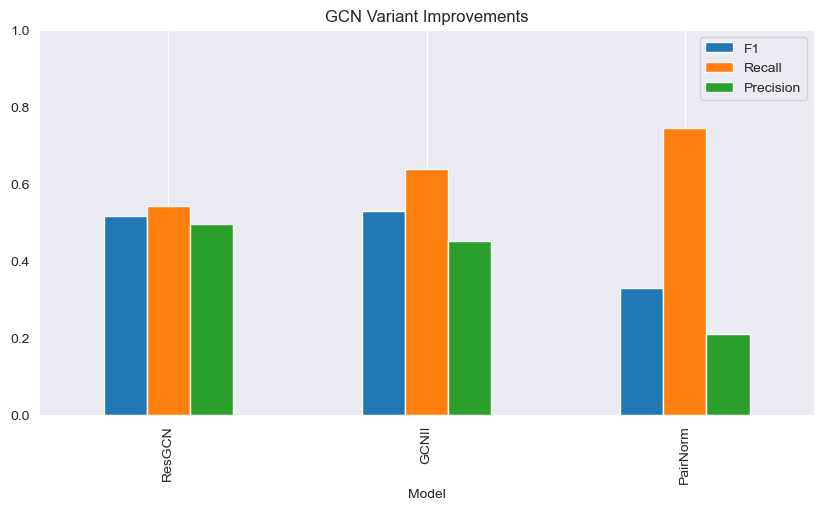

In [1]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, ModuleList
from torch_geometric.nn import GCNConv, GCN2Conv, PairNorm
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用的设备: {device}")

# ==========================================
# 1. 加载数据
# ==========================================
try:
    data = torch.load('../data/processed/elliptic_pyg.pt', weights_only=False)
    data = data.to(device)
    print("数据加载成功！")
except FileNotFoundError:
    print("❌ 错误：找不到数据文件。")

# 计算类别权重 (不变)
num_neg = (data.y[data.train_mask] == 0).sum().item()
num_pos = (data.y[data.train_mask] == 1).sum().item()
pos_weight = torch.tensor([num_neg / num_pos]).to(device)
print(f"正样本权重: {pos_weight.item():.2f}")

# ==========================================
# 2. 定义三种改进模型
# ==========================================

# --- 模型 A: ResGCN (带残差连接的 GCN) ---
# 核心思想：保留原始特征，防止被邻居带偏
class ResGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ResGCN, self).__init__()
        # 1. 线性投影层：把 165维 变成 128维，方便后面做残差相加
        self.lin_in = Linear(in_channels, hidden_channels)

        # 2. GCN 层
        self.conv1 = GCNConv(hidden_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # 投影
        x = self.lin_in(x)
        x = F.relu(x)
        identity = x  # 保存这一刻的特征 (Residual)

        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # --- 残差连接 (Skip Connection) ---
        # 这里的逻辑是：卷积后的结果 + 卷积前的结果
        # 这保证了即使卷积层学废了，至少还能保留上一层的信息
        x = x + identity

        # Layer 2
        x = self.conv2(x, edge_index)
        return x

# --- 模型 B: GCNII (GCN with Initial Residual & Identity Mapping) ---
# 核心思想：可以堆叠很深 (16层)，解决过平滑，捕捉长距离依赖
class DeepGCNII(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=16, alpha=0.1, theta=0.5):
        super(DeepGCNII, self).__init__()
        self.lin1 = Linear(in_channels, hidden_channels)
        self.convs = ModuleList()

        # 修改点：将 _ 改为 i，以便获取层数索引
        for i in range(num_layers):
            # 关键修改：传入 layer=i+1
            # GCNII 需要知道当前是第几层来计算衰减系数 beta
            self.convs.append(GCN2Conv(hidden_channels, alpha, theta, layer=i+1))

        self.lin2 = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        x_0 = x  # 保存初始特征 (Initial Residual)

        for conv in self.convs:
            # GCNII 需要同时传入 x 和 x_0
            x = conv(x, x_0, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.5, training=self.training)

        x = self.lin2(x)
        return x

# --- 模型 C: GCN + PairNorm (图结构重归一化) ---
# 核心思想：在卷积后强制拉开节点距离，对抗“好人包围坏人”的平滑
class GCN_PairNorm(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN_PairNorm, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.pn = PairNorm() # 重归一化层
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.pn(x) # <--- 关键插入点：强制把挤在一起的节点推开
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        return x

# ==========================================
# 3. 训练函数 (复用)
# ==========================================
def train_and_eval(model, name, epochs=200, lr=0.01):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    # 处理不平衡
    class_weights = torch.tensor([1.0, pos_weight.item()]).to(device)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

    print(f"\n>>> 开始训练 {name} ...")
    loss_history = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    # 评估
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)

        y_true = data.y[data.test_mask].cpu().numpy()
        y_pred = pred[data.test_mask].cpu().numpy()

        f1 = f1_score(y_true, y_pred, pos_label=1)
        rec = recall_score(y_true, y_pred, pos_label=1)
        prec = precision_score(y_true, y_pred, pos_label=1)

        print(f"✅ {name} 结果: F1={f1:.4f} | Recall={rec:.4f} | Precision={prec:.4f}")
        return {'F1': f1, 'Recall': rec, 'Precision': prec, 'Loss': loss_history}

# ==========================================
# 4. 运行对比实验
# ==========================================

# 1. ResGCN
res_gcn = ResGCN(data.num_features, 128, 2)
res_res = train_and_eval(res_gcn, "ResGCN (Residual)", lr=0.01)

# 2. GCNII (深层) - 设为 8 层试试
gcnii = DeepGCNII(data.num_features, 128, 2, num_layers=8, alpha=0.1, theta=0.5)
gcnii_res = train_and_eval(gcnii, "GCNII (8 Layers)", lr=0.01)

# 3. PairNorm
pn_gcn = GCN_PairNorm(data.num_features, 128, 2)
pn_res = train_and_eval(pn_gcn, "GCN + PairNorm", lr=0.01)

# --- 可视化对比 ---
results_df = pd.DataFrame([
    {'Model': 'ResGCN', **res_res},
    {'Model': 'GCNII', **gcnii_res},
    {'Model': 'PairNorm', **pn_res}
]).set_index('Model')

print("\n>>> 改进模型对比结果 <<<")
print(results_df[['F1', 'Recall', 'Precision']])

results_df[['F1', 'Recall', 'Precision']].plot(kind='bar', figsize=(10, 5))
plt.title("GCN Variant Improvements")
plt.ylim(0, 1.0)
plt.grid(axis='y')
plt.show()

使用的设备: cuda
数据加载成功！
👉 使用手动权重: Licit=0.3, Illicit=0.7

>>> 开始训练 ResGCN (Residual) ...
✅ ResGCN (Residual) 结果: F1=0.5848 | Recall=0.6066 | Precision=0.5644
👉 使用手动权重: Licit=0.3, Illicit=0.7

>>> 开始训练 GCNII (8 Layers) ...
✅ GCNII (8 Layers) 结果: F1=0.6282 | Recall=0.5826 | Precision=0.6814
👉 使用手动权重: Licit=0.3, Illicit=0.7

>>> 开始训练 GCN + PairNorm ...
✅ GCN + PairNorm 结果: F1=0.4809 | Recall=0.6454 | Precision=0.3832

>>> 改进模型对比结果 <<<
                F1    Recall  Precision
Model                                  
ResGCN    0.584780  0.606648   0.564433
GCNII     0.628173  0.582641   0.681425
PairNorm  0.480908  0.645429   0.383224


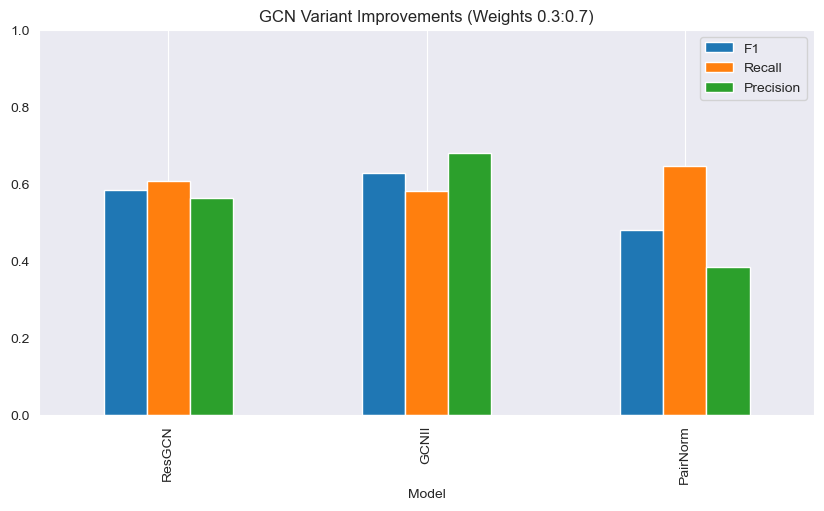

In [2]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, ModuleList
from torch_geometric.nn import GCNConv, GCN2Conv, PairNorm
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用的设备: {device}")

# ==========================================
# 1. 加载数据
# ==========================================
try:
    data = torch.load('../data/processed/elliptic_pyg.pt', weights_only=False)
    data = data.to(device)
    print("数据加载成功！")
except FileNotFoundError:
    print("❌ 错误：找不到数据文件。")

# ==========================================
# 2. 定义三种改进模型
# ==========================================

# --- 模型 A: ResGCN (带残差连接的 GCN) ---
class ResGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ResGCN, self).__init__()
        self.lin_in = Linear(in_channels, hidden_channels)
        self.conv1 = GCNConv(hidden_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.lin_in(x)
        x = F.relu(x)
        identity = x  # 保存初始残差

        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # 残差连接: 卷积结果 + 原始投影
        x = x + identity

        # Layer 2
        x = self.conv2(x, edge_index)
        return x

# --- 模型 B: GCNII (已修复 AssertionError) ---
class DeepGCNII(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=16, alpha=0.1, theta=0.5):
        super(DeepGCNII, self).__init__()
        self.lin1 = Linear(in_channels, hidden_channels)
        self.convs = ModuleList()

        for i in range(num_layers):
            # 🛠️ 修复点：传入 layer=i+1
            self.convs.append(GCN2Conv(hidden_channels, alpha, theta, layer=i+1))

        self.lin2 = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        x_0 = x  # Initial Residual

        for conv in self.convs:
            # GCNII 需要传入 x 和 x_0
            x = conv(x, x_0, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.5, training=self.training)

        x = self.lin2(x)
        return x

# --- 模型 C: GCN + PairNorm ---
class GCN_PairNorm(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN_PairNorm, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.pn = PairNorm()
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.pn(x) # 强制拉开特征距离
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# ==========================================
# 3. 训练函数 (已更新权重策略)
# ==========================================
def train_and_eval(model, name, epochs=200, lr=0.01):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

    # 🛠️ 修复点：使用文献建议的权重 [0.3, 0.7]
    # Class 0 (Licit): 0.3 | Class 1 (Illicit): 0.7
    manual_weights = torch.tensor([0.3, 0.7]).to(device)
    print(f"👉 使用手动权重: Licit=0.3, Illicit=0.7")

    criterion = torch.nn.CrossEntropyLoss(weight=manual_weights)

    print(f"\n>>> 开始训练 {name} ...")
    loss_history = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    # 评估
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)

        y_true = data.y[data.test_mask].cpu().numpy()
        y_pred = pred[data.test_mask].cpu().numpy()

        f1 = f1_score(y_true, y_pred, pos_label=1)
        rec = recall_score(y_true, y_pred, pos_label=1)
        prec = precision_score(y_true, y_pred, pos_label=1)

        print(f"✅ {name} 结果: F1={f1:.4f} | Recall={rec:.4f} | Precision={prec:.4f}")
        return {'F1': f1, 'Recall': rec, 'Precision': prec}

# ==========================================
# 4. 运行对比实验
# ==========================================

# 1. ResGCN
res_gcn = ResGCN(data.num_features, 128, 2)
res_res = train_and_eval(res_gcn, "ResGCN (Residual)", lr=0.01)

# 2. GCNII (深层 8 层)
gcnii = DeepGCNII(data.num_features, 128, 2, num_layers=8, alpha=0.1, theta=0.5)
gcnii_res = train_and_eval(gcnii, "GCNII (8 Layers)", lr=0.01)

# 3. PairNorm
pn_gcn = GCN_PairNorm(data.num_features, 128, 2)
pn_res = train_and_eval(pn_gcn, "GCN + PairNorm", lr=0.01)

# --- 可视化对比 ---
results_df = pd.DataFrame([
    {'Model': 'ResGCN', **res_res},
    {'Model': 'GCNII', **gcnii_res},
    {'Model': 'PairNorm', **pn_res}
]).set_index('Model')

print("\n>>> 改进模型对比结果 <<<")
print(results_df)

results_df[['F1', 'Recall', 'Precision']].plot(kind='bar', figsize=(10, 5))
plt.title("GCN Variant Improvements (Weights 0.3:0.7)")
plt.ylim(0, 1.0)
plt.grid(axis='y')
plt.show()